In [1]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dataset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import easydict

In [3]:
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)

In [4]:
args = easydict.EasyDict({
    "dataroot":"/mnt/gold/users/s18150/mywork/pytorch/data/gan",
    "workers": 8,
    "batch_size": 128,
    "image_size": 64,
    "nc": 3,
    "nz": 100,
    "ngf": 64,
    "ndf": 64,
    "epochs": 1,
    "lr": 0.0002,
    "beta1": 0.5,
    "gpu": 9,
    "feature_matching": True,
    "mini_batch": True
})

In [21]:
transform = transforms.Compose([
    transforms.Resize(args.image_size),
    transforms.CenterCrop(args.image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))    
])

In [5]:
dataset = dataset.ImageFolder(root=args.dataroot,transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=args.batch_size,
                                        shuffle=True, num_workers=args.workers)


In [6]:
device = torch.device('cuda:{}'.format(args.gpu) if (torch.cuda.is_available() and args.gpu > 0) else 'cpu')

In [7]:
# real_batch = next(iter(dataloader))
# plt.figure(figsize=(8,8))
# plt.axis('off')
# plt.title('Traning Image')
# plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64],
#                        padding=2,normalize=True).cpu(),(1,2,0)))

In [14]:
# モデルの初期化用の関数
# DCGANによるとCNN層の初期値は、平均0、偏差0.2で乱数初期化
# BatchNormの部分が何故平均1になっているかは調査が必要

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [22]:
class Generator(nn.Module):
    def __init__(self, nz, ngf, nc):
        super(Generator, self).__init__()
#         self.gpu = args.gpu

##upsampleinで得られる画像サイズ = (W - 1) x stride - 2xpadding + kernel + outputpadding

        self.model = nn.Sequential(
            # 乱数z, generatorのconv層への入力
            # 層の深さ ngfx8, kernel: 4, stride: 1, padding: 0
            # サイズ: (1-1)x 1 - 2x0 + 4 = 4
            nn.ConvTranspose2d(nz, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),
            # 層の深さ ngfx4, kernel: 4, stride: 2, padding: 1
            # サイズ: (4-1)x 2 - 2x1 + 4 = 8
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            # 層の深さ ngfx2, kernel: 4, stride: 2, padding: 1
            # サイズ: (8-1)x 2 - 2x1 + 4 = 16
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),
            # 層の深さ ngfx2, kernel: 4, stride: 2, padding: 1
            # サイズ: (16-1)x 2 - 2x1 + 4 = 32
            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # 層の深さ ngfx2, kernel: 4, stride: 2, padding: 1
            # サイズ: (32-1)x 2 - 2x1 + 4 = 64
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    
    def forward(self, input):
        return self.model(input)

In [23]:
## Generator用のモデルのインスタンス作成
netG = Generator(args.nz, args.ngf, args.nc).to(device)
## Generator用のモデルの初期値を設定
netG.apply(weights_init)

Generator(
  (model): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [28]:
class MiniBatchDiscriminator(nn.Module):
    def __init__(self, A, B, C, device):
        
        super(MiniBatchDiscriminator, self).__init__()
        self.A, self.B, self.C = A, B, C
        self.device = device
        T_init = torch.randn([A, B, C])
        self.T = nn.Parameter(T_init, requires_grad=True).to(device)
        
    def forward(self, x):
        
        batch_size = x.size()[0]
        self.T = (self.T).view([self.A, -1])
        M = x.mm(self.T)
        M = M.view(-1, self.B, self.C)        
        M_ex2 = M.unsqueeze(-1)
        M_ex2_T = torch.transpose(M_ex2, 0, 3)
        M_ex2 = M_ex2.expand(batch_size, -1, -1, batch_size)
        M_ex2_T = M_ex2_T.expand(batch_size, -1, -1, batch_size)        

        norm2 = torch.sum(torch.abs(M_ex2 - M_ex2_T), dim=2)

        eraser = torch.eye(batch_size).view(batch_size, 1, batch_size).to(self.device)
        eraser = eraser.expand_as(norm2)
        
        c_b2 = torch.exp(-(norm2 + 1e6 * eraser))
        o_b2 = torch.sum(c_b2, dim=2)
        
        output = torch.cat((x, o_b2), 1)
        
        return output

In [29]:
class Discriminator(nn.Module):
    def __init__(self, nc, ndf, device, minibatch=True):
        super(Discriminator, self).__init__()
        self.ndf = ndf
        self.A = ndf*8*4*4
        self.B = 128
        self.C = 16
        T_init = torch.randn([self.A, self.B, self.C])
        self.T = nn.Parameter(T_init, requires_grad=True).to(device)
        
        self.minibatch_flag = minibatch
        
        self.minibatch = MiniBatchDiscriminator(self.A, self.B, self.C, device)
        
#         self.T = torch.Tensor(self.T).reshape([self.A, self.B, self.C])
        self.device = device
        self.model1 = nn.Sequential(
            # SIZE = (W + 2xpadding - kernel) / stride + 1      
            # nc x 64 x 64 >> (64 + 2x1 - 4)/2 +1 = 32
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # (ndf) x 32 x 32 >> (32 + 2x1 - 4)/2 +1 = 16
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),
            # (ndf) x 16 x 16 >> (16 + 2x1 - 4)/2 +1 = 8
            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),
            # (ndf) x 8 x 8 >> (8 + 2x1 - 4)/2 +1 = 4
            nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
#         self.LeakyReLU = nn.LeakyReLU(0.2, inplace=True)
        self.cnv = nn.Conv2d(ndf*8, 1, 4, 1, 0, bias=False)
        self.fn = nn.Linear(ndf*8*4*4, 1)
        self.fn_mb = nn.Linear(ndf*8*4*4 + self.B, 1)
        self.sigmoid = nn.Sigmoid()
        
        self.model2 = nn.Sequential(        
            # (ndf) x 4 x 4 >> (4 + 2x0 - 4)/1 +1 = 1 >> 1つの値を出力
            nn.LeakyReLU(0.2, inplace=True),      
            nn.Conv2d(ndf*8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()                
        )
        

        
    def forward(self, input, feature_matching = False):
#         Batch = input.size()[0]

        h1 = self.model1(input)
#         h1 = self.LeakyReLU(h1)
        x = h1.view(-1, self.ndf*8*4*4)
        
        ########################## mini-batch ##########################
         
#         self.T = (self.T).view([self.A, -1])
#         M = x.mm(self.T)
#         M = M.view(-1, self.B, self.C)        
#         M_ex2 = M.unsqueeze(-1)
# #         M_ex2 = M_ex2.expand(-1,-1,-1,3)
#         M_ex2_T = torch.transpose(M_ex2, 0, 3)
# #         dim0 = max(M_ex2.size()[0], M_ex2_T.size()[0])
# #         dim3 = max(M_ex2.size()[3], M_ex2_T.size()[3])
# #         M_ex2 = M_ex2.expand(dim0, -1, -1, dim3)
# #         M_ex2_T = M_ex2_T.expand(dim0, -1, -1, dim3)        
#         M_ex2 = M_ex2.expand(Batch, -1, -1, Batch)
#         M_ex2_T = M_ex2_T.expand(Batch, -1, -1, Batch)        

#         norm2 = torch.sum(torch.abs(M_ex2 - M_ex2_T), dim=2)

#         eraser = torch.eye(Batch).view(Batch, 1, Batch).to(self.device)
#         eraser = eraser.expand_as(norm2)
        
# #         print(eraser.type())
# #         print(norm2.type())

#         c_b2 = torch.exp(-(norm2 + 1e6 * eraser))
#         o_b2 = torch.sum(c_b2, dim=2)
        
        if self.minibatch_flag ==True:
            x = self.minibatch(x)
        
#         x = torch.cat((x, o_b2), 1)
        ################################################################
                
#         h2 = self.cnv(h1)  # 最終層をcnn
#         h2 = self.fn(x)  # 最終層を全結合
        h2 = self.fn_mb(x) # mini-batch用
        
        output = self.sigmoid(h2)        
#         output = self.model2(h1)
        
        if feature_matching == True:
#             feature = h1.view(-1, self.ndf*8*4*4)
            feature = x
            return output, feature
        else:
            return output, 0
    

In [31]:
## Discriminator用のモデルのインスタンス作成
netD = Discriminator(args.nc, args.ndf, device, args.mini_batch).to(device)
## Discriminator用のモデルの初期値を設定
netD.apply(weights_init)

Discriminator(
  (minibatch): MiniBatchDiscriminator()
  (model1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
  )
  (cnv): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (fn): Linear(in_features=8192

loss関数としてnn.BCELoss()を使用  
BCELoss()の中身は下記  
$loss(x,y) = L = {l_1, ..., l_N}$  
$l_n = -w_n [y_n \cdot \log x_n + (1 - y_n) \cdot \log(1 - x_n)]$  
$loss(x,y) = mean(L)$, if size_average = True  
$loss(x,y) = sum(L)$, if size_average = False  
$w_n$: weight parameter

In [32]:
# BCE Loss classのインスタンスを作成
criterionD = nn.BCELoss()

if args.feature_matching == True:
    criterionG = nn.MSELoss(reduction='elementwise_mean')
else:
    criterionG = nn.BCELoss()

# Generatorに入力するノイズをバッチごとに作成 (バッチ数は64)
# これはGeneratorの結果を描画するために使用する
fixed_noise = torch.randn(64, args.nz, 1, 1, device=device)

# real dataとface dataのラベルを作成
real_label = 1
fake_label = 0

# 最適化関数のインスタンスを作成
optimizerD = optim.Adam(netD.parameters(), lr=args.lr, betas=(args.beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=args.lr, betas=(args.beta1, 0.999))


In [33]:
img_list = []
G_losses = []
D_losses = []
iters = 0

for epoch in range(args.epochs):
    for i, data in enumerate(dataloader, 0):
        
        netD.zero_grad()
        real_data = data[0].to(device)
        batch_size = real_data.size(0)
        ''' <https://github.com/soumith/ganhacks によると、
        real dataとfakeデータを個別に学習する方が精度がよいとの検証結果があるため、
        このコードもその検証結果をフォローする'''
        
        ################# Discriminator の real dataを学習 #####################
        # real data の正解ラベルのベクトル をバッチサイズ分用意
        # 長さ batch size のベクトルをreal_label = 1 で埋める
        label = torch.full((batch_size,), real_label, device=device)
        # Discriminator のreal dataのforwardを計算
        output, feature_real = netD(real_data, args.feature_matching)
        output = output.view(-1)
        # Discriminator の real dataのlossを計算
        # cross entropy = -y log x - (1 - y) log(1 -x)
        # label はすべて1に設定しているため、fake dataのloss を表す２項目はすべて0になる
        errD_real = criterionD(output, label)
        # feature_mating のロス計算で再利用るため、retaing_graph=Trueにする
        errD_real.backward(retain_graph=True) 
#         errD_real.backward() 
        # Discriminatorの出力値の平均、ナッシュ均衡点は0.5
        D_x = output.mean().item()
        
        ################# Discriminator の fake dataを学習 #####################
        noise = torch.randn(batch_size, args.nz, 1, 1, device=device)
        # args.nzの長さの乱数のベクトルをGeneratorのネットワークに入力
        fake_data = netG(noise)
        # labelをすべてfake_labelで埋める、batch sizeはreal と fakeで同じサイズを前提
        label.fill_(fake_label)
        # Discriminator の fake data のforwardを計算
        # このときGeneratorは学習しないため、fake_dataのrequired_gradをすべてfalseにする
        output, _ = netD(fake_data.detach())
        output = output.view(-1)
        # Discriminator の fake dataのlossを計算
        # cross entropy = -y log x - (1 - y) log(1 -x)
        # label はすべて0に設定しているため、fake dataのloss を表す1項目はすべて0になる
        errD_fake = criterionD(output, label)
        errD_fake.backward()
        # Discriminatorの出力値の平均、ナッシュ均衡点は0.5
        D_G_z1 = output.mean().item()
        # Discriminatorのloss
        errD = errD_real - errD_fake
        # netDのパラメータを更新
        optimizerD.step()
        
        ################# Generator の fake dataを学習 #####################
        netG.zero_grad()
        # Generatorの場合、Discriminatorを騙すため、ラベルはすべて1(正解)で設定する
        # その時の log(D(G(z)))を最大化することがGeneratorの目的
        label.fill_(real_label)
        # 今度はfake_dataをdetachしない
#         if args.feature_matching == True:
#             _, feature_real = netD(real_data.detach(), args.feature_matching)
        output, feature_fake = netD(fake_data, args.feature_matching)
        # Generatorのlossを計算、Generatorの目的は (1 - log(D(G(z))))を最小化すること
        # しかし通常勾配消失が生じてうまく学習できない
        # そのため、log()D(G(z))を最大化することを目的とする
        # そのため、labelを1にセットし、cross entropy の第一項を使用する
        
        if args.feature_matching == True:
            feature_real = torch.mean(feature_real,0)
            feature_fake = torch.mean(feature_fake, 0)
            errG = criterionG(feature_real.detach(), feature_fake)
        else:
            errG = criterionG(output, label)
            
        errG.backward()
        D_G_z2 = output.mean().item()
        # netGのパラメータを更新
        optimizerG.step()
        
        if i % 50:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, args.epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))        
        
        # ロスを保存
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        if (iters % 500 == 0) or ((epoch == args.epochs - 1) and (i == len(dataloader) - 1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
        
        iters += 1
        

[0/1][1/1583]	Loss_D: -0.7661	Loss_G: 958.5521	D(x): 0.9044	D(G(z)): 0.5737 / 0.0167
[0/1][2/1583]	Loss_D: -0.1032	Loss_G: 857.2578	D(x): 0.8894	D(G(z)): 0.2123 / 0.0118
[0/1][3/1583]	Loss_D: 0.0501	Loss_G: 794.7445	D(x): 0.8439	D(G(z)): 0.1580 / 0.0169
[0/1][4/1583]	Loss_D: 0.0491	Loss_G: 703.3770	D(x): 0.8543	D(G(z)): 0.1467 / 0.0205
[0/1][5/1583]	Loss_D: 0.0659	Loss_G: 645.2924	D(x): 0.8696	D(G(z)): 0.1044 / 0.0235
[0/1][6/1583]	Loss_D: -0.0657	Loss_G: 731.3972	D(x): 0.9329	D(G(z)): 0.1380 / 0.0135
[0/1][7/1583]	Loss_D: -0.0172	Loss_G: 772.9064	D(x): 0.9212	D(G(z)): 0.1308 / 0.0091
[0/1][8/1583]	Loss_D: 0.0367	Loss_G: 694.4973	D(x): 0.9266	D(G(z)): 0.0529 / 0.0122
[0/1][9/1583]	Loss_D: 0.0344	Loss_G: 652.8594	D(x): 0.9179	D(G(z)): 0.0869 / 0.0160
[0/1][10/1583]	Loss_D: -0.0702	Loss_G: 793.5574	D(x): 0.9465	D(G(z)): 0.1250 / 0.0070
[0/1][11/1583]	Loss_D: 0.0690	Loss_G: 724.2496	D(x): 0.9073	D(G(z)): 0.0717 / 0.0088
[0/1][12/1583]	Loss_D: 0.0681	Loss_G: 738.1799	D(x): 0.9240	D(G(z)): 

[0/1][98/1583]	Loss_D: -0.4425	Loss_G: 419.4973	D(x): 0.9560	D(G(z)): 0.3590 / 0.0159
[0/1][99/1583]	Loss_D: 0.2874	Loss_G: 174.1863	D(x): 0.7406	D(G(z)): 0.0903 / 0.0700
[0/1][101/1583]	Loss_D: -0.0193	Loss_G: 250.1006	D(x): 0.8754	D(G(z)): 0.1446 / 0.0347
[0/1][102/1583]	Loss_D: 0.0646	Loss_G: 252.2754	D(x): 0.8039	D(G(z)): 0.1621 / 0.0797
[0/1][103/1583]	Loss_D: -0.3294	Loss_G: 467.4958	D(x): 0.8932	D(G(z)): 0.3404 / 0.0032
[0/1][104/1583]	Loss_D: 1.6877	Loss_G: 387.7592	D(x): 0.2580	D(G(z)): 0.0181 / 0.9185
[0/1][105/1583]	Loss_D: -2.2713	Loss_G: 1128.6395	D(x): 0.9954	D(G(z)): 0.8466 / 0.0016
[0/1][106/1583]	Loss_D: 1.1510	Loss_G: 170.8728	D(x): 0.4338	D(G(z)): 0.0118 / 0.0344
[0/1][107/1583]	Loss_D: 0.0478	Loss_G: 263.5702	D(x): 0.8648	D(G(z)): 0.1077 / 0.1235
[0/1][108/1583]	Loss_D: -0.2700	Loss_G: 276.3294	D(x): 0.9294	D(G(z)): 0.2778 / 0.0480
[0/1][109/1583]	Loss_D: -0.0814	Loss_G: 280.7492	D(x): 0.9127	D(G(z)): 0.1625 / 0.0284
[0/1][110/1583]	Loss_D: 0.1722	Loss_G: 215.3423	D

[0/1][195/1583]	Loss_D: -0.0019	Loss_G: 245.1596	D(x): 0.8649	D(G(z)): 0.1389 / 0.0413
[0/1][196/1583]	Loss_D: 0.2278	Loss_G: 148.9645	D(x): 0.7601	D(G(z)): 0.0988 / 0.2167
[0/1][197/1583]	Loss_D: -0.3973	Loss_G: 364.6836	D(x): 0.9393	D(G(z)): 0.3335 / 0.0070
[0/1][198/1583]	Loss_D: 0.7994	Loss_G: 115.5527	D(x): 0.5254	D(G(z)): 0.0257 / 0.4333
[0/1][199/1583]	Loss_D: -0.8240	Loss_G: 485.8002	D(x): 0.9754	D(G(z)): 0.5153 / 0.0061
[0/1][201/1583]	Loss_D: -0.4164	Loss_G: 321.3779	D(x): 0.9621	D(G(z)): 0.3277 / 0.0198
[0/1][202/1583]	Loss_D: 0.1933	Loss_G: 175.8950	D(x): 0.7886	D(G(z)): 0.0794 / 0.0658
[0/1][203/1583]	Loss_D: 0.0559	Loss_G: 166.9044	D(x): 0.8581	D(G(z)): 0.1075 / 0.1013
[0/1][204/1583]	Loss_D: -0.1574	Loss_G: 251.8597	D(x): 0.9134	D(G(z)): 0.2242 / 0.0252
[0/1][205/1583]	Loss_D: 0.1671	Loss_G: 143.3984	D(x): 0.8142	D(G(z)): 0.0674 / 0.0777
[0/1][206/1583]	Loss_D: -0.1008	Loss_G: 224.6095	D(x): 0.9174	D(G(z)): 0.1674 / 0.0342
[0/1][207/1583]	Loss_D: 0.1414	Loss_G: 145.9962	

[0/1][292/1583]	Loss_D: -0.0454	Loss_G: 239.7401	D(x): 0.9245	D(G(z)): 0.1307 / 0.0210
[0/1][293/1583]	Loss_D: 0.1476	Loss_G: 141.9733	D(x): 0.8281	D(G(z)): 0.0559 / 0.1135
[0/1][294/1583]	Loss_D: -0.2512	Loss_G: 307.2533	D(x): 0.9532	D(G(z)): 0.2435 / 0.0070
[0/1][295/1583]	Loss_D: 0.4102	Loss_G: 122.3746	D(x): 0.6887	D(G(z)): 0.0215 / 0.2296
[0/1][296/1583]	Loss_D: -0.3904	Loss_G: 339.4610	D(x): 0.9730	D(G(z)): 0.3057 / 0.0084
[0/1][297/1583]	Loss_D: 0.1432	Loss_G: 181.8862	D(x): 0.8672	D(G(z)): 0.0250 / 0.0244
[0/1][298/1583]	Loss_D: 0.1008	Loss_G: 147.7494	D(x): 0.8613	D(G(z)): 0.0639 / 0.1098
[0/1][299/1583]	Loss_D: -0.1599	Loss_G: 270.0032	D(x): 0.9479	D(G(z)): 0.1797 / 0.0120
[0/1][301/1583]	Loss_D: -0.1721	Loss_G: 245.9391	D(x): 0.9515	D(G(z)): 0.1806 / 0.0193
[0/1][302/1583]	Loss_D: 0.0608	Loss_G: 190.1417	D(x): 0.8905	D(G(z)): 0.0685 / 0.0345
[0/1][303/1583]	Loss_D: 0.0131	Loss_G: 159.8162	D(x): 0.9005	D(G(z)): 0.0936 / 0.0433
[0/1][304/1583]	Loss_D: 0.0066	Loss_G: 187.0985	D

[0/1][390/1583]	Loss_D: 0.0542	Loss_G: 119.7662	D(x): 0.8708	D(G(z)): 0.0849 / 0.0535
[0/1][391/1583]	Loss_D: 0.0835	Loss_G: 103.0486	D(x): 0.8442	D(G(z)): 0.0925 / 0.1425
[0/1][392/1583]	Loss_D: -0.2086	Loss_G: 189.0775	D(x): 0.9213	D(G(z)): 0.2368 / 0.0169
[0/1][393/1583]	Loss_D: 0.3553	Loss_G: 93.4986	D(x): 0.7167	D(G(z)): 0.0466 / 0.1894
[0/1][394/1583]	Loss_D: -0.3445	Loss_G: 251.0932	D(x): 0.9588	D(G(z)): 0.2934 / 0.0101
[0/1][395/1583]	Loss_D: 0.3854	Loss_G: 101.0502	D(x): 0.7176	D(G(z)): 0.0313 / 0.1316
[0/1][396/1583]	Loss_D: -0.1816	Loss_G: 182.5932	D(x): 0.9587	D(G(z)): 0.1910 / 0.0409
[0/1][397/1583]	Loss_D: -0.0083	Loss_G: 180.3115	D(x): 0.9146	D(G(z)): 0.0949 / 0.0314
[0/1][398/1583]	Loss_D: 0.1578	Loss_G: 108.5369	D(x): 0.8300	D(G(z)): 0.0651 / 0.1036
[0/1][399/1583]	Loss_D: -0.0856	Loss_G: 161.0016	D(x): 0.9230	D(G(z)): 0.1491 / 0.0406
[0/1][401/1583]	Loss_D: 0.0678	Loss_G: 106.5539	D(x): 0.8637	D(G(z)): 0.0872 / 0.1028
[0/1][402/1583]	Loss_D: -0.0349	Loss_G: 123.6975	D

[0/1][487/1583]	Loss_D: 0.0863	Loss_G: 93.7327	D(x): 0.8432	D(G(z)): 0.0983 / 0.1290
[0/1][488/1583]	Loss_D: -0.1249	Loss_G: 170.7532	D(x): 0.9402	D(G(z)): 0.1672 / 0.0205
[0/1][489/1583]	Loss_D: 0.2584	Loss_G: 88.1656	D(x): 0.7734	D(G(z)): 0.0629 / 0.2081
[0/1][490/1583]	Loss_D: -0.2745	Loss_G: 237.6074	D(x): 0.9620	D(G(z)): 0.2410 / 0.0082
[0/1][491/1583]	Loss_D: 0.2871	Loss_G: 97.0203	D(x): 0.7727	D(G(z)): 0.0181 / 0.1436
[0/1][492/1583]	Loss_D: -0.2016	Loss_G: 199.0276	D(x): 0.9639	D(G(z)): 0.1970 / 0.0199
[0/1][493/1583]	Loss_D: 0.1650	Loss_G: 92.0448	D(x): 0.8101	D(G(z)): 0.0710 / 0.1200
[0/1][494/1583]	Loss_D: -0.0778	Loss_G: 147.5696	D(x): 0.9249	D(G(z)): 0.1426 / 0.0388
[0/1][495/1583]	Loss_D: 0.0484	Loss_G: 122.2923	D(x): 0.8852	D(G(z)): 0.0799 / 0.0546
[0/1][496/1583]	Loss_D: 0.0101	Loss_G: 130.1297	D(x): 0.9082	D(G(z)): 0.0884 / 0.0553
[0/1][497/1583]	Loss_D: -0.0121	Loss_G: 139.7002	D(x): 0.9140	D(G(z)): 0.1046 / 0.0501
[0/1][498/1583]	Loss_D: 0.0042	Loss_G: 130.9910	D(x):

[0/1][584/1583]	Loss_D: -0.1579	Loss_G: 162.3099	D(x): 0.9595	D(G(z)): 0.1694 / 0.0229
[0/1][585/1583]	Loss_D: 0.1495	Loss_G: 87.2988	D(x): 0.8402	D(G(z)): 0.0452 / 0.0858
[0/1][586/1583]	Loss_D: -0.0743	Loss_G: 126.2058	D(x): 0.9284	D(G(z)): 0.1358 / 0.0440
[0/1][587/1583]	Loss_D: 0.0288	Loss_G: 120.8890	D(x): 0.9066	D(G(z)): 0.0700 / 0.0476
[0/1][588/1583]	Loss_D: 0.0876	Loss_G: 87.5748	D(x): 0.8621	D(G(z)): 0.0745 / 0.1127
[0/1][589/1583]	Loss_D: -0.1449	Loss_G: 181.9352	D(x): 0.9533	D(G(z)): 0.1681 / 0.0198
[0/1][590/1583]	Loss_D: 0.2132	Loss_G: 73.0244	D(x): 0.7934	D(G(z)): 0.0475 / 0.1661
[0/1][591/1583]	Loss_D: -0.1583	Loss_G: 139.3802	D(x): 0.9445	D(G(z)): 0.1864 / 0.0286
[0/1][592/1583]	Loss_D: 0.0231	Loss_G: 116.9221	D(x): 0.8973	D(G(z)): 0.0844 / 0.0381
[0/1][593/1583]	Loss_D: 0.1268	Loss_G: 83.2267	D(x): 0.8588	D(G(z)): 0.0452 / 0.1116
[0/1][594/1583]	Loss_D: -0.1924	Loss_G: 192.4887	D(x): 0.9656	D(G(z)): 0.1894 / 0.0157
[0/1][595/1583]	Loss_D: 0.2225	Loss_G: 86.6233	D(x): 

[0/1][682/1583]	Loss_D: 1.5522	Loss_G: 80.5742	D(x): 0.3316	D(G(z)): 0.0216 / 0.2823
[0/1][683/1583]	Loss_D: -0.4926	Loss_G: 128.1678	D(x): 0.8955	D(G(z)): 0.3883 / 0.0408
[0/1][684/1583]	Loss_D: 0.1247	Loss_G: 124.3495	D(x): 0.8374	D(G(z)): 0.0764 / 0.0403
[0/1][685/1583]	Loss_D: 0.1912	Loss_G: 73.0716	D(x): 0.7719	D(G(z)): 0.1079 / 0.1773
[0/1][686/1583]	Loss_D: -0.3624	Loss_G: 150.5349	D(x): 0.9345	D(G(z)): 0.3068 / 0.0159
[0/1][687/1583]	Loss_D: 0.6039	Loss_G: 60.8366	D(x): 0.5930	D(G(z)): 0.0451 / 0.3136
[0/1][688/1583]	Loss_D: -0.4653	Loss_G: 176.1868	D(x): 0.9558	D(G(z)): 0.3656 / 0.0183
[0/1][689/1583]	Loss_D: 0.1039	Loss_G: 119.7394	D(x): 0.8461	D(G(z)): 0.0729 / 0.0315
[0/1][690/1583]	Loss_D: 0.2196	Loss_G: 78.6113	D(x): 0.7886	D(G(z)): 0.0618 / 0.1559
[0/1][691/1583]	Loss_D: -0.1488	Loss_G: 124.4733	D(x): 0.9340	D(G(z)): 0.1856 / 0.0527
[0/1][692/1583]	Loss_D: -0.0486	Loss_G: 134.8469	D(x): 0.9210	D(G(z)): 0.1165 / 0.0273
[0/1][693/1583]	Loss_D: 0.0644	Loss_G: 113.3940	D(x):

[0/1][780/1583]	Loss_D: 0.0370	Loss_G: 90.8703	D(x): 0.9084	D(G(z)): 0.0640 / 0.0435
[0/1][781/1583]	Loss_D: 0.0205	Loss_G: 90.6393	D(x): 0.9051	D(G(z)): 0.0758 / 0.0612
[0/1][782/1583]	Loss_D: -0.0275	Loss_G: 108.1264	D(x): 0.9373	D(G(z)): 0.0884 / 0.0441
[0/1][783/1583]	Loss_D: 0.0667	Loss_G: 89.2864	D(x): 0.8839	D(G(z)): 0.0648 / 0.0748
[0/1][784/1583]	Loss_D: -0.0538	Loss_G: 100.3339	D(x): 0.9405	D(G(z)): 0.1037 / 0.0496
[0/1][785/1583]	Loss_D: 0.0178	Loss_G: 94.4620	D(x): 0.9145	D(G(z)): 0.0716 / 0.0511
[0/1][786/1583]	Loss_D: 0.0013	Loss_G: 103.3554	D(x): 0.9308	D(G(z)): 0.0728 / 0.0457
[0/1][787/1583]	Loss_D: 0.0901	Loss_G: 93.7730	D(x): 0.8653	D(G(z)): 0.0717 / 0.1232
[0/1][788/1583]	Loss_D: -0.1949	Loss_G: 149.6341	D(x): 0.9622	D(G(z)): 0.1908 / 0.0120
[0/1][789/1583]	Loss_D: 0.2659	Loss_G: 81.3498	D(x): 0.7688	D(G(z)): 0.0322 / 0.1278
[0/1][790/1583]	Loss_D: -0.1875	Loss_G: 147.1071	D(x): 0.9594	D(G(z)): 0.1932 / 0.0215
[0/1][791/1583]	Loss_D: 0.2311	Loss_G: 79.2143	D(x): 0.7

[0/1][878/1583]	Loss_D: -0.2919	Loss_G: 212.9256	D(x): 0.9764	D(G(z)): 0.2460 / 0.0033
[0/1][879/1583]	Loss_D: 0.5193	Loss_G: 69.7734	D(x): 0.6458	D(G(z)): 0.0095 / 0.4395
[0/1][880/1583]	Loss_D: -0.7647	Loss_G: 347.2347	D(x): 0.9907	D(G(z)): 0.4815 / 0.0007
[0/1][881/1583]	Loss_D: 1.1627	Loss_G: 117.1306	D(x): 0.4000	D(G(z)): 0.0046 / 0.8022
[0/1][882/1583]	Loss_D: -2.4937	Loss_G: 498.9742	D(x): 0.9977	D(G(z)): 0.8337 / 0.0003
[0/1][883/1583]	Loss_D: 1.9283	Loss_G: 122.2585	D(x): 0.2565	D(G(z)): 0.0031 / 0.5815
[0/1][884/1583]	Loss_D: -1.0536	Loss_G: 191.9033	D(x): 0.9646	D(G(z)): 0.5476 / 0.0124
[0/1][885/1583]	Loss_D: 0.1478	Loss_G: 122.5307	D(x): 0.8351	D(G(z)): 0.0619 / 0.0233
[0/1][886/1583]	Loss_D: 0.3580	Loss_G: 68.5140	D(x): 0.7169	D(G(z)): 0.0707 / 0.2853
[0/1][887/1583]	Loss_D: -0.5569	Loss_G: 200.3058	D(x): 0.9626	D(G(z)): 0.3986 / 0.0063
[0/1][888/1583]	Loss_D: 0.6418	Loss_G: 61.0343	D(x): 0.5916	D(G(z)): 0.0265 / 0.2185
[0/1][889/1583]	Loss_D: -0.2353	Loss_G: 103.8792	D(x

[0/1][976/1583]	Loss_D: -0.0940	Loss_G: 87.9159	D(x): 0.8866	D(G(z)): 0.1879 / 0.0720
[0/1][977/1583]	Loss_D: 0.0130	Loss_G: 84.4808	D(x): 0.8453	D(G(z)): 0.1474 / 0.0657
[0/1][978/1583]	Loss_D: 0.0026	Loss_G: 92.3689	D(x): 0.8892	D(G(z)): 0.1110 / 0.0527
[0/1][979/1583]	Loss_D: 0.1305	Loss_G: 72.4554	D(x): 0.8399	D(G(z)): 0.0617 / 0.1072
[0/1][980/1583]	Loss_D: -0.1598	Loss_G: 98.5259	D(x): 0.9140	D(G(z)): 0.2103 / 0.0311
[0/1][981/1583]	Loss_D: 0.1199	Loss_G: 78.1736	D(x): 0.8480	D(G(z)): 0.0605 / 0.0639
[0/1][982/1583]	Loss_D: -0.0031	Loss_G: 108.9703	D(x): 0.9044	D(G(z)): 0.0939 / 0.0749
[0/1][983/1583]	Loss_D: -0.0387	Loss_G: 111.0204	D(x): 0.9198	D(G(z)): 0.1171 / 0.0489
[0/1][984/1583]	Loss_D: 0.0128	Loss_G: 93.3412	D(x): 0.9111	D(G(z)): 0.0813 / 0.0433
[0/1][985/1583]	Loss_D: 0.0306	Loss_G: 93.8455	D(x): 0.8838	D(G(z)): 0.0987 / 0.0615
[0/1][986/1583]	Loss_D: 0.0242	Loss_G: 93.8601	D(x): 0.9221	D(G(z)): 0.0580 / 0.0535
[0/1][987/1583]	Loss_D: -0.0213	Loss_G: 91.1226	D(x): 0.940

[0/1][1073/1583]	Loss_D: -0.1009	Loss_G: 127.1198	D(x): 0.9703	D(G(z)): 0.1174 / 0.0130
[0/1][1074/1583]	Loss_D: 0.1596	Loss_G: 70.2314	D(x): 0.8568	D(G(z)): 0.0222 / 0.1384
[0/1][1075/1583]	Loss_D: -0.1973	Loss_G: 180.2401	D(x): 0.9710	D(G(z)): 0.1850 / 0.0048
[0/1][1076/1583]	Loss_D: 0.2983	Loss_G: 75.9306	D(x): 0.7671	D(G(z)): 0.0174 / 0.3066
[0/1][1077/1583]	Loss_D: -0.3520	Loss_G: 234.7101	D(x): 0.9867	D(G(z)): 0.2717 / 0.0015
[0/1][1078/1583]	Loss_D: 0.3990	Loss_G: 77.3546	D(x): 0.7135	D(G(z)): 0.0084 / 0.2528
[0/1][1079/1583]	Loss_D: -0.4711	Loss_G: 266.6676	D(x): 0.9809	D(G(z)): 0.3241 / 0.0012
[0/1][1080/1583]	Loss_D: 0.7255	Loss_G: 105.8946	D(x): 0.5666	D(G(z)): 0.0036 / 0.8573
[0/1][1081/1583]	Loss_D: -2.4343	Loss_G: 639.1006	D(x): 0.9974	D(G(z)): 0.8140 / 0.0000
[0/1][1082/1583]	Loss_D: 4.7312	Loss_G: 407.5666	D(x): 0.0304	D(G(z)): 0.0004 / 0.9776
[0/1][1083/1583]	Loss_D: -6.0120	Loss_G: 366.8838	D(x): 0.9992	D(G(z)): 0.9794 / 0.0144
[0/1][1084/1583]	Loss_D: 0.9785	Loss_G: 

[0/1][1170/1583]	Loss_D: 0.0386	Loss_G: 78.7868	D(x): 0.9218	D(G(z)): 0.0456 / 0.0446
[0/1][1171/1583]	Loss_D: 0.0100	Loss_G: 74.6837	D(x): 0.9222	D(G(z)): 0.0687 / 0.0647
[0/1][1172/1583]	Loss_D: -0.0410	Loss_G: 97.9851	D(x): 0.9394	D(G(z)): 0.0931 / 0.0311
[0/1][1173/1583]	Loss_D: 0.0165	Loss_G: 102.3564	D(x): 0.9243	D(G(z)): 0.0628 / 0.0380
[0/1][1174/1583]	Loss_D: 0.0024	Loss_G: 93.4993	D(x): 0.9412	D(G(z)): 0.0587 / 0.0386
[0/1][1175/1583]	Loss_D: -0.0028	Loss_G: 102.2055	D(x): 0.9366	D(G(z)): 0.0669 / 0.0335
[0/1][1176/1583]	Loss_D: 0.0080	Loss_G: 93.3142	D(x): 0.9343	D(G(z)): 0.0625 / 0.0338
[0/1][1177/1583]	Loss_D: 0.0393	Loss_G: 85.6228	D(x): 0.9196	D(G(z)): 0.0485 / 0.0546
[0/1][1178/1583]	Loss_D: -0.0023	Loss_G: 83.5078	D(x): 0.9140	D(G(z)): 0.0907 / 0.0601
[0/1][1179/1583]	Loss_D: -0.0479	Loss_G: 105.1902	D(x): 0.9472	D(G(z)): 0.0951 / 0.0192
[0/1][1180/1583]	Loss_D: 0.0795	Loss_G: 79.9131	D(x): 0.8975	D(G(z)): 0.0417 / 0.0607
[0/1][1181/1583]	Loss_D: -0.0281	Loss_G: 104.63

[0/1][1267/1583]	Loss_D: -0.0473	Loss_G: 89.1811	D(x): 0.9518	D(G(z)): 0.0879 / 0.0345
[0/1][1268/1583]	Loss_D: 0.0212	Loss_G: 84.3201	D(x): 0.9133	D(G(z)): 0.0718 / 0.0422
[0/1][1269/1583]	Loss_D: -0.0014	Loss_G: 95.0869	D(x): 0.9394	D(G(z)): 0.0632 / 0.0376
[0/1][1270/1583]	Loss_D: 0.0037	Loss_G: 99.3261	D(x): 0.9366	D(G(z)): 0.0597 / 0.0361
[0/1][1271/1583]	Loss_D: -0.0256	Loss_G: 111.7291	D(x): 0.9538	D(G(z)): 0.0683 / 0.0260
[0/1][1272/1583]	Loss_D: 0.0978	Loss_G: 90.3372	D(x): 0.8772	D(G(z)): 0.0440 / 0.0938
[0/1][1273/1583]	Loss_D: -0.0787	Loss_G: 98.9542	D(x): 0.9600	D(G(z)): 0.1072 / 0.0274
[0/1][1274/1583]	Loss_D: 0.0492	Loss_G: 82.9754	D(x): 0.9075	D(G(z)): 0.0520 / 0.0490
[0/1][1275/1583]	Loss_D: -0.0282	Loss_G: 84.0291	D(x): 0.9423	D(G(z)): 0.0826 / 0.0332
[0/1][1276/1583]	Loss_D: 0.0253	Loss_G: 82.6273	D(x): 0.9210	D(G(z)): 0.0664 / 0.0433
[0/1][1277/1583]	Loss_D: 0.0229	Loss_G: 85.8472	D(x): 0.9287	D(G(z)): 0.0546 / 0.0476
[0/1][1278/1583]	Loss_D: -0.0142	Loss_G: 95.3851

[0/1][1364/1583]	Loss_D: 0.1090	Loss_G: 74.6049	D(x): 0.8752	D(G(z)): 0.0399 / 0.0872
[0/1][1365/1583]	Loss_D: -0.1014	Loss_G: 96.1825	D(x): 0.9593	D(G(z)): 0.1252 / 0.0264
[0/1][1366/1583]	Loss_D: 0.0542	Loss_G: 89.0531	D(x): 0.9042	D(G(z)): 0.0487 / 0.0475
[0/1][1367/1583]	Loss_D: 0.0030	Loss_G: 87.2174	D(x): 0.9334	D(G(z)): 0.0666 / 0.0547
[0/1][1368/1583]	Loss_D: -0.0588	Loss_G: 87.5156	D(x): 0.9475	D(G(z)): 0.1015 / 0.0261
[0/1][1369/1583]	Loss_D: 0.0718	Loss_G: 73.0037	D(x): 0.9038	D(G(z)): 0.0375 / 0.0567
[0/1][1370/1583]	Loss_D: 0.0205	Loss_G: 70.8636	D(x): 0.9141	D(G(z)): 0.0687 / 0.0765
[0/1][1371/1583]	Loss_D: -0.0645	Loss_G: 95.4714	D(x): 0.9625	D(G(z)): 0.0975 / 0.0222
[0/1][1372/1583]	Loss_D: 0.1002	Loss_G: 68.6606	D(x): 0.8774	D(G(z)): 0.0447 / 0.0802
[0/1][1373/1583]	Loss_D: -0.0652	Loss_G: 97.8906	D(x): 0.9614	D(G(z)): 0.0943 / 0.0315
[0/1][1374/1583]	Loss_D: 0.0267	Loss_G: 83.1480	D(x): 0.9242	D(G(z)): 0.0541 / 0.0432
[0/1][1375/1583]	Loss_D: -0.0140	Loss_G: 99.1836	D

[0/1][1461/1583]	Loss_D: -1.5442	Loss_G: 123.8210	D(x): 0.8994	D(G(z)): 0.7020 / 0.0219
[0/1][1462/1583]	Loss_D: 2.3250	Loss_G: 62.2702	D(x): 0.1778	D(G(z)): 0.0690 / 0.6521
[0/1][1463/1583]	Loss_D: -1.0933	Loss_G: 84.3257	D(x): 0.8746	D(G(z)): 0.6324 / 0.1149
[0/1][1464/1583]	Loss_D: 0.3532	Loss_G: 73.3564	D(x): 0.6032	D(G(z)): 0.2145 / 0.2243
[0/1][1465/1583]	Loss_D: -0.2443	Loss_G: 63.8777	D(x): 0.7824	D(G(z)): 0.3487 / 0.1254
[0/1][1466/1583]	Loss_D: 0.1013	Loss_G: 38.9697	D(x): 0.6670	D(G(z)): 0.2746 / 0.1831
[0/1][1467/1583]	Loss_D: 0.2444	Loss_G: 37.9571	D(x): 0.6160	D(G(z)): 0.2491 / 0.3990
[0/1][1468/1583]	Loss_D: -0.5545	Loss_G: 65.2072	D(x): 0.8628	D(G(z)): 0.4696 / 0.0359
[0/1][1469/1583]	Loss_D: 1.0517	Loss_G: 42.3002	D(x): 0.3702	D(G(z)): 0.0802 / 0.7111
[0/1][1470/1583]	Loss_D: -1.3169	Loss_G: 90.1835	D(x): 0.9502	D(G(z)): 0.6800 / 0.0241
[0/1][1471/1583]	Loss_D: 0.8406	Loss_G: 43.6601	D(x): 0.4723	D(G(z)): 0.0593 / 0.2825
[0/1][1472/1583]	Loss_D: -0.2458	Loss_G: 53.7470

[0/1][1558/1583]	Loss_D: -0.0562	Loss_G: 95.0317	D(x): 0.9558	D(G(z)): 0.0912 / 0.0216
[0/1][1559/1583]	Loss_D: 0.0368	Loss_G: 80.2581	D(x): 0.9323	D(G(z)): 0.0357 / 0.0321
[0/1][1560/1583]	Loss_D: 0.0497	Loss_G: 74.9104	D(x): 0.9130	D(G(z)): 0.0470 / 0.0767
[0/1][1561/1583]	Loss_D: -0.1133	Loss_G: 115.5700	D(x): 0.9660	D(G(z)): 0.1287 / 0.0108
[0/1][1562/1583]	Loss_D: 0.1260	Loss_G: 69.5671	D(x): 0.8750	D(G(z)): 0.0204 / 0.0626
[0/1][1563/1583]	Loss_D: -0.0537	Loss_G: 95.6388	D(x): 0.9583	D(G(z)): 0.0878 / 0.0315
[0/1][1564/1583]	Loss_D: -0.0038	Loss_G: 86.6758	D(x): 0.9411	D(G(z)): 0.0647 / 0.0277
[0/1][1565/1583]	Loss_D: 0.0272	Loss_G: 74.6076	D(x): 0.9296	D(G(z)): 0.0468 / 0.0465
[0/1][1566/1583]	Loss_D: 0.0098	Loss_G: 85.7280	D(x): 0.9340	D(G(z)): 0.0591 / 0.0453
[0/1][1567/1583]	Loss_D: -0.0227	Loss_G: 79.1590	D(x): 0.9476	D(G(z)): 0.0744 / 0.0276
[0/1][1568/1583]	Loss_D: 0.0101	Loss_G: 79.6200	D(x): 0.9347	D(G(z)): 0.0558 / 0.0311
[0/1][1569/1583]	Loss_D: 0.0323	Loss_G: 76.0587	

In [34]:
img_list2 = img_list

In [49]:
img = [np.transpose(i.numpy(), (1,2,0)) for i in img_list]
img = np.array(img)

In [9]:
%ls

180303-gan.ipynb            errorD_minibach_feature.npy  net.py
dataset.py                  errorG_minibach_feature.npy  None0000000.png
DCGAN-improved-Copy1.ipynb  img_minibach_feature.npy     __pycache__/
DCGAN-improved-Copy2.ipynb  img.npy                      run.py
DCGAN-improved.ipynb        logger.py                    vat.py
DCGAN.ipynb                 main_dcgan.py


In [10]:
np.save('img', img)

NameError: name 'img' is not defined

In [43]:
img = img_list[-1].numpy()

In [44]:
img = np.transpose(img, (1,2,0))

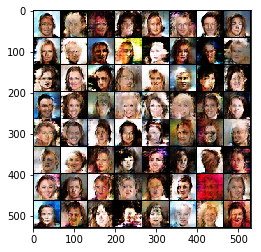

In [45]:
plt.imshow(img)

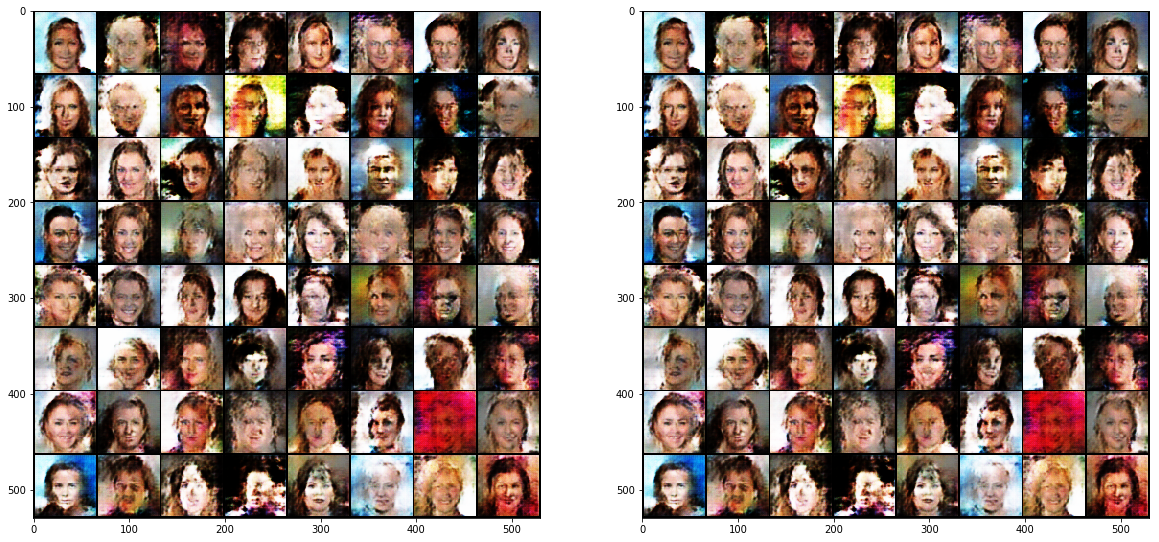

In [35]:
# img_list: feature matching + minibatch [left]
# img_list2: minibatch [right]
fig, axs = plt.subplots(1,2, figsize=(20,10))
axs[0].imshow(np.transpose(img_list[-1], (1,2,0)))
axs[1].imshow(np.transpose(img_list2[-1], (1,2,0)))

In [11]:
img_list2 = np.load('img_minibach_feature.npy')

In [12]:
img_list2.shape

(7, 530, 530, 3)

In [13]:
fig = plt.figure(figsize = (8,8))

In [2]:
img1 = np.load('./result/img_no_imporve.npy')
img2 = np.load('./result/img_feature.npy')
img3 = np.load('img_minibach_feature.npy')

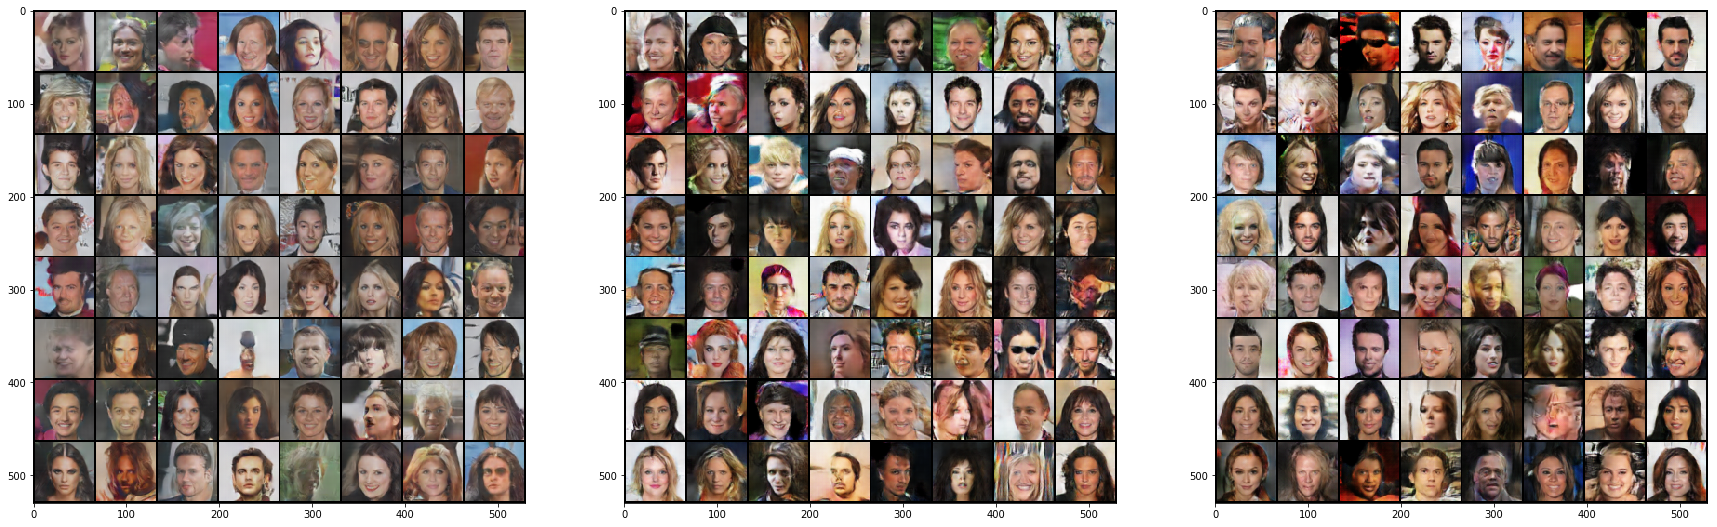

In [4]:
fig, axs = plt.subplots(1,3, figsize=(30,10))
axs[0].imshow(img1[-1])
axs[1].imshow(img2[-1])
axs[2].imshow(img3[-1])

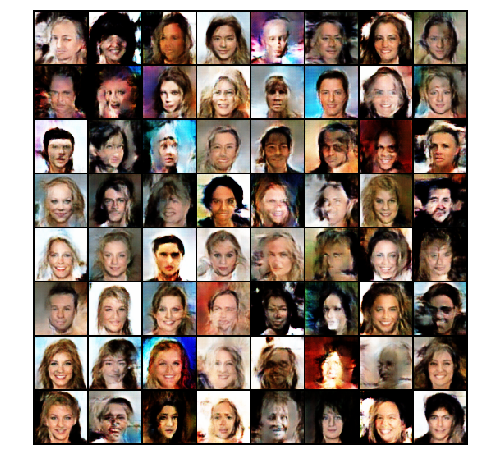

In [14]:
fig = plt.figure(figsize = (8,8))
plt.axis('off')
# ims = [[plt.imshow(np.transpose(i, (1,2,0)), animated=True)] for i in img_list2]
ims = [[plt.imshow(i, animated=True)] for i in img_list2]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
real_batch = next(iter(dataloader))

In [ ]:
plt.figure(figsize=(25,25))
plt.subplot(1,2,1)
plt.axis('off')
plt.title('Real Images')
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5,
                                        normalize=True).cpu(),(1,2,0)))
plt.subplot(1,2,2)
plt.axis('off')
plt.title('Fake Images')
plt.imshow(np.transpose(img_list[-1],(1,2,0)))

In [15]:
img_list = []
G_losses = []
D_losses = []
iters = 0

i = 0
it = iter(dataloader)
data = next(it)


In [16]:
data[0].size()

torch.Size([128, 3, 64, 64])

In [20]:
netD.zero_grad()
real_data = data[0].to(device)
batch_size = real_data.size(0)
label = torch.full((batch_size,), real_label, device=device)

In [35]:
output, feature = netD(real_data, feature_matching=True)

In [36]:
feature.size()

torch.Size([2048, 512])

In [37]:
output.size()

torch.Size([128, 1, 1, 1])

In [63]:
a = torch.Tensor([1,2,3])
b = torch.Tensor([4,5,6])

In [69]:
l = nn.MSELoss(reduction='elementwise_mean')
l(a, b)

tensor(9.)

## Mini-batchの動作サンプル

In [15]:
Batch = 5
A = 4
B = 2
C = 3

In [16]:
T = np.random.randn(A*B*C)
T = torch.Tensor(T).reshape([A,B,C])

In [17]:
x = np.random.randn(Batch*A)
x = torch.Tensor(x).reshape([Batch,A]) #batch = 2, feature map size = 5

In [18]:
T = T.reshape([A, -1])
M = x.mm(T)
M = M.reshape(-1, B, C)

## Case 1: for文によるmini-batch

In [19]:
out_tensor = []

In [20]:
for i in range(M.size()[0]):
    out_i = None
    for j in range(M.size()[0]):
        if i == j:
            continue
            
        o_i = torch.sum(torch.abs(M[i,:,:] - M[j,:,:]), 1)
        o_i = torch.exp(-o_i)
        print(o_i)
        if out_i is None:
            out_i = o_i
        else:
            out_i += o_i
    out_tensor.append(out_i)

tensor([0.0027, 0.0015])
tensor([6.2969e-06, 1.7910e-03])
tensor([0.0268, 0.0322])
tensor([0.0017, 0.0125])
tensor([0.0027, 0.0015])
tensor([0.0019, 0.0001])
tensor([0.0020, 0.0000])
tensor([0.4628, 0.0018])
tensor([6.2969e-06, 1.7910e-03])
tensor([0.0019, 0.0001])
tensor([3.8675e-06, 4.3100e-02])
tensor([0.0029, 0.0000])
tensor([0.0268, 0.0322])
tensor([0.0020, 0.0000])
tensor([3.8675e-06, 4.3100e-02])
tensor([0.0013, 0.0004])
tensor([0.0017, 0.0125])
tensor([0.4628, 0.0018])
tensor([0.0029, 0.0000])
tensor([0.0013, 0.0004])


In [21]:
out_T = torch.cat(tuple(out_tensor)).view(M.size()[0], B)

## Case2: テンソル演算によるmini-batch[chainer]

In [22]:
from chainer import functions as cF
import chainer

In [23]:
M_np = M.numpy()
M_np_ex = cF.expand_dims(M_np, 3)
M_np_ex_T = cF.transpose(M_np_ex, (3,1,2,0))

In [24]:
print(M_np.shape)
print(M_np_ex.shape)
print(M_np_ex_T.shape)

(5, 2, 3)
(5, 2, 3, 1)
(1, 2, 3, 5)


In [25]:
M_np_ex, M_np_ex_T = cF.broadcast(M_np_ex, M_np_ex_T)

In [26]:
print(M_np.shape)
print(M_np_ex.shape)
print(M_np_ex_T.shape)

(5, 2, 3)
(5, 2, 3, 5)
(5, 2, 3, 5)


In [27]:
xp = chainer.cuda.get_array_module(x.numpy())
norm = cF.sum(abs(M_np_ex - M_np_ex_T), axis=2)
eraser = cF.broadcast_to(xp.eye(Batch).reshape((Batch, 1, Batch)), norm.shape)

In [28]:
c_b = cF.exp(-(norm.data + 1e6 * eraser.data))
o_b = cF.sum(c_b, axis=2)

In [29]:
out_T

tensor([[0.0311, 0.0479],
        [0.4693, 0.0034],
        [0.0048, 0.0450],
        [0.0301, 0.0758],
        [0.4687, 0.0147]])

## Case3: テンソルによるmini-batch [pytorch]

In [30]:
M_ex2 = M.unsqueeze(-1)
# M_ex2 = M_ex2.expand(-1,-1,-1,3)

In [31]:
M_ex2_T = torch.transpose(M_ex2, 0, 3)

In [32]:
dim0 = max(M_ex2.size()[0], M_ex2_T.size()[0])
dim3 = max(M_ex2.size()[3], M_ex2_T.size()[3])
print(dim0)
print(dim3)

5
5


In [33]:
M_ex2 = M_ex2.expand(dim0, -1, -1, dim3)
M_ex2_T = M_ex2_T.expand(dim0, -1, -1, dim3)

In [34]:
norm2 = torch.sum(torch.abs(M_ex2 - M_ex2_T), dim=2)

In [35]:
eraser = torch.eye(Batch).view(Batch, 1, Batch)
eraser = eraser.expand_as(norm2)

In [36]:
c_b2 = torch.exp(-(norm2 + 1e6 * eraser))
o_b2 = torch.sum(c_b2, dim=2)

In [44]:
a = torch.eye(Batch)
a.size()

torch.Size([5, 5])

In [46]:
b = a.view(Batch, 1, Batch)
b.size()

torch.Size([5, 1, 5])

In [48]:
b

tensor([[[1., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0.]],

        [[0., 0., 1., 0., 0.]],

        [[0., 0., 0., 1., 0.]],

        [[0., 0., 0., 0., 1.]]])

In [37]:
o_b2

tensor([[0.0311, 0.0479],
        [0.4693, 0.0034],
        [0.0048, 0.0450],
        [0.0301, 0.0758],
        [0.4687, 0.0147]])

In [38]:
o_b

variable([[0.03109907, 0.04794177],
          [0.4693477 , 0.0033683 ],
          [0.00480035, 0.04498814],
          [0.03013877, 0.07576251],
          [0.46866381, 0.01473812]])

In [39]:
torch.distributions.utils.broadcast_all()

[]

In [60]:
c = b[:3,:,:3]

In [61]:
print(b.size())
print(c.size())

torch.Size([5, 1, 5])
torch.Size([3, 1, 3])
